In [70]:
import dynamic_pricing.db.db_utils as db
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [71]:
df: pd.DataFrame = db.load_order_data("nostimo")
print(df.info)

2024-02-16 14:55:07,965 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-02-16 14:55:07,966 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2024-02-16 14:55:07,967 INFO sqlalchemy.engine.Engine [cached since 3777s ago] {'table_name': "\n                SELECT\n                    orders.order_id,\n                    orders.deliveroo_order_id,\n                    orders.deliveroo_ ... (1796 characters truncated) ... r_item_modifiers.modifier_id = modifiers.modifier_id\n                WHERE\n                    partners.partner_name = 'nostimo';\n                ", 'param_1':

2024-02-16 14:55:08,161 INFO sqlalchemy.engine.Engine 
                SELECT
                    orders.order_id,
                    orders.deliveroo_order_id,
                    orders.deliveroo_order_number,
                    orders.order_status,
                    orders.order_placed_timestamp,
                    orders.order_updated_timestamp,
                    customers.customer_id,
                    customers.first_name,
                    customers.contact_number,
                    customers.contact_access_code,
                    partners.partner_id,
                    partners.partner_name,
                    items.item_id,
                    items.deliveroo_item_id,
                    items.item_name,
                    items.item_operational_name,
                    order_items.quantity AS item_quantity,
                    order_items.fractional_price AS item_fractional_price,
                    modifiers.modifier_id,
                    modifiers.deli

In [72]:
print(df.columns)
df.head()

Index(['order_id', 'deliveroo_order_id', 'deliveroo_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'deliveroo_item_id',
       'item_name', 'item_operational_name', 'item_quantity',
       'item_fractional_price', 'modifier_id', 'deliveroo_modifier_id',
       'modifier_name', 'modifier_operational_name', 'modifier_quantity',
       'modifier_fractional_price'],
      dtype='object')


,order_id,deliveroo_order_id,deliveroo_order_number,order_status,order_placed_timestamp,order_updated_timestamp,customer_id,first_name,contact_number,contact_access_code,...,item_name,item_operational_name,item_quantity,item_fractional_price,modifier_id,deliveroo_modifier_id,modifier_name,modifier_operational_name,modifier_quantity,modifier_fractional_price
0,2,gb:b7fb9b03-3db5-4b4d-ae04-52682288688d,10047859061,accepted,2023-10-22 15:49:41,2023-10-22 15:51:36,2.0,Teng,442033195035,716304438,...,Grilled Halloumi Cheese,Grilled Halloumi Cheese (Starters and Sharers),1,750,None,None,None,None,None,None
1,2,gb:b7fb9b03-3db5-4b4d-ae04-52682288688d,10047859061,accepted,2023-10-22 15:49:41,2023-10-22 15:51:36,2.0,Teng,442033195035,716304438,...,Tzatziki Dip,Tzatziki Dip (Starters and Sharers),1,600,None,None,None,None,None,None
2,2,gb:b7fb9b03-3db5-4b4d-ae04-52682288688d,10047859061,accepted,2023-10-22 15:49:41,2023-10-22 15:51:36,2.0,Teng,442033195035,716304438,...,Meat Gemista,Meat Gemista (Traditional Homemade Recipes),1,1650,None,None,None,None,None,None
3,122,gb:0ab2d2d8-8e99-43d5-b4a3-2564658be424,1867854755,accepted,2023-07-08 17:47:11,2023-07-08 17:47:54,NaN,None,None,None,...,Chicken Gyros,Chicken Gyros (Handmade Mains From The Grill),1,1700,None,None,None,None,None,None
4,122,gb:0ab2d2d8-8e99-43d5-b4a3-2564658be424,1867854755,accepted,2023-07-08 17:47:11,2023-07-08 17:47:54,NaN,None,None,None,...,Greek Salad,Greek Salad (Starters and Sharers),1,1050,None,None,None,None,None,None


analysis

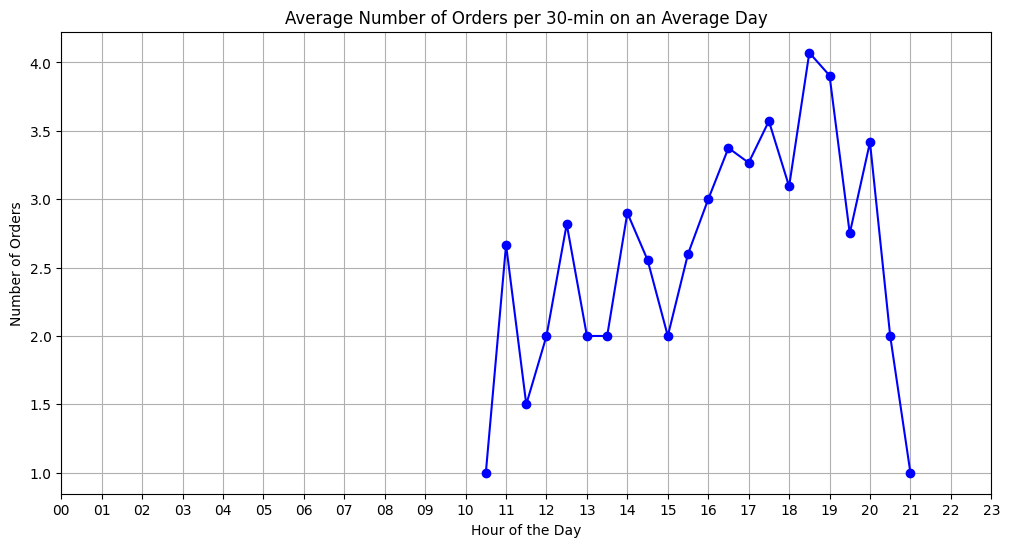

In [73]:
def plot_average_orders_per_interval(df: pd.DataFrame, interval: int):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60
        + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the actual average number of orders for each interval on an average day
    actual_average_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .mean()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting the expected orders per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        actual_average_orders, marker="o", linestyle="-", color="blue", markersize=6
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Orders")45
    plt.title(f"Average Number of Orders per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.show()

df["interval_index"] = (
        df["order_placed_timestamp"].dt.hour * 60
        + df["order_placed_timestamp"].dt.minute
    ) // 30

plot_average_orders_per_interval(df,interval=30)

/tmp/ipykernel_116859/2771430743.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


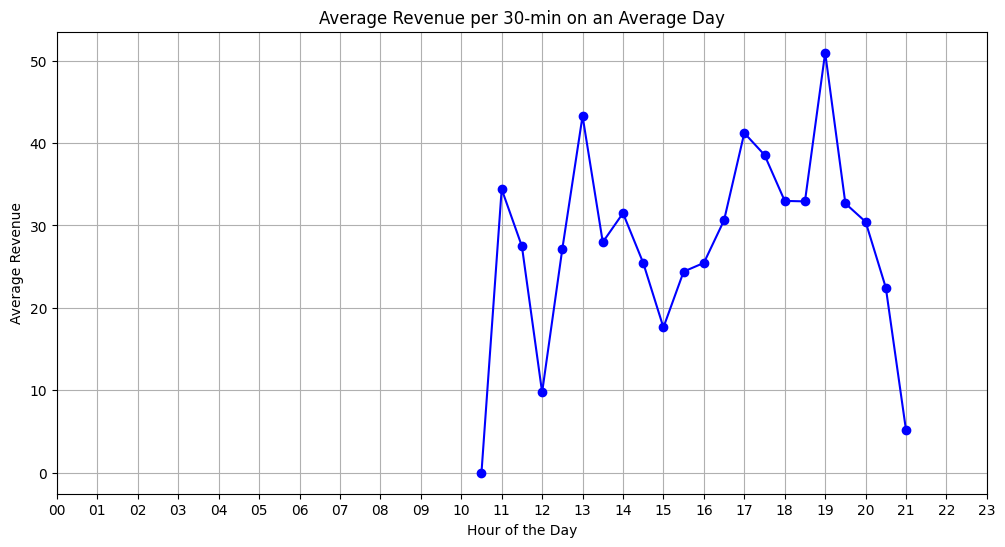

In [74]:
def plot_average_revenue_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Calculate the actual average revenue for each interval on an average day
    # df['revenue'] = df["order_total_price"]/100
    df = df[["order_id","item_quantity","item_fractional_price","modifier_fractional_price","modifier_quantity",order_timestamp]].copy()
    df.fillna(0, inplace=True)

    df["order_value"] = ((df["item_fractional_price"] * df["item_quantity"]) + (df["modifier_fractional_price"] * df["modifier_quantity"]))/100
    df['revenue'] = df.groupby('order_id')['order_value'].sum()

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval


    actual_average_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .mean()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting the average revenue per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        actual_average_revenue, marker="o", linestyle="-", color="blue", markersize=6
    )
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Revenue')
    plt.title(f'Average Revenue per {interval}-min on an Average Day')
    plt.xticks(range(0, num_intervals, int(60 / interval)),
                x_labels)
    plt.grid(True)
    plt.show()

plot_average_revenue_per_interval(df,30)

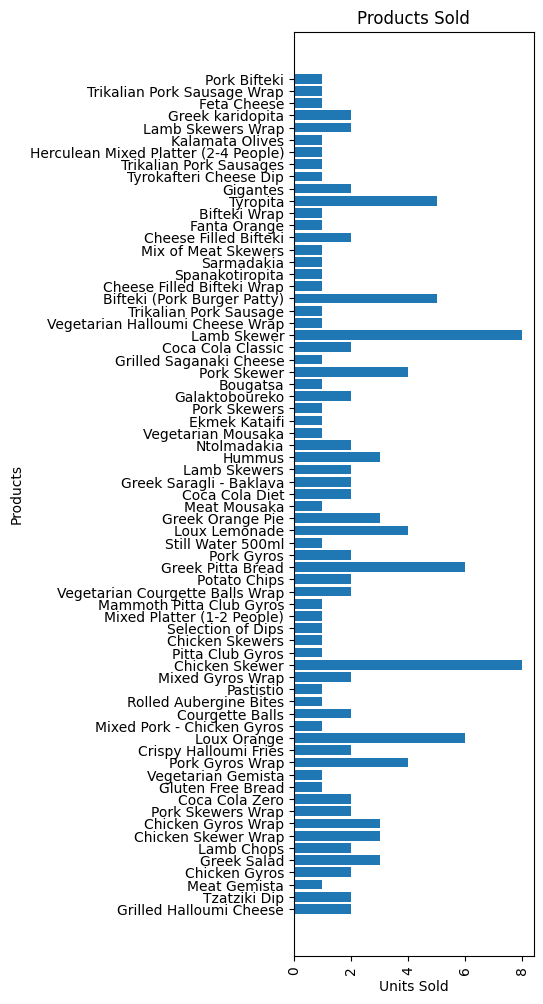

In [75]:
def plot_items_sold(df):
    df = df[["order_id","item_name","item_quantity"]].copy()

    plt.figure(figsize=(6, 12))
    plt.barh(df["item_name"], df["item_quantity"])
    plt.ylabel('Products')
    plt.xlabel('Units Sold')
    plt.title('Products Sold')
    plt.xticks(rotation=90)
    plt.subplots_adjust(left=0.5)  # Adjust the value as needed
    plt.show()

plot_items_sold(df)

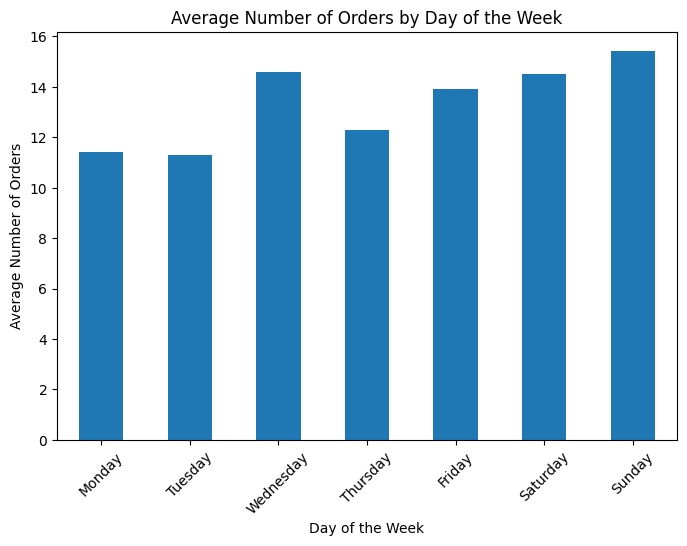

In [76]:

def plot_average_orders_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Extract the day of the week from the order_datetime column
    df['day_of_week'] = df[order_timestamp].dt.day_name()

    # Group by day of the week and calculate the average number of orders
    average_orders = df.groupby(['day_of_week', df[order_timestamp].dt.date]).size().groupby('day_of_week').mean()

    # Define the order of days for proper sorting in the plot
    weekdays = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Reindex the DataFrame to include all weekdays in the desired order
    average_orders = average_orders.reindex(weekdays)

    # Plotting the average number of orders by day of the week
    plt.figure(figsize=(8, 6))
    average_orders.plot(kind='bar')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Number of Orders')
    plt.title('Average Number of Orders by Day of the Week')
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.2)
    plt.show()

plot_average_orders_by_day_of_week(df)

/tmp/ipykernel_116859/2506019107.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


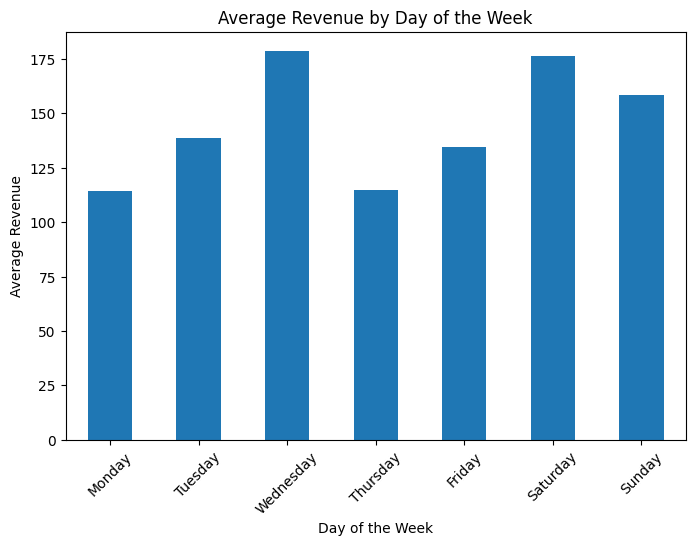

In [77]:
def plot_average_revenue_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Calculate the average revenue by day of the week
    # df["revenue"] = df["order_total_price"] / 100
    # average_revenue_by_day = df.groupby("day_of_week")["revenue"].mean()
    df = df[["order_id","item_quantity","item_fractional_price","modifier_fractional_price","modifier_quantity",order_timestamp]].copy()
    df.fillna(0, inplace=True)

    df["order_value"] = ((df["item_fractional_price"] * df["item_quantity"]) + (df["modifier_fractional_price"] * df["modifier_quantity"]))/100
    df['revenue'] = df.groupby('order_id')['order_value'].sum()

    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    average_revenue_by_day = df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"].sum().groupby("day_of_week").mean()

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    average_revenue_by_day = average_revenue_by_day.reindex(weekdays)
    # Plotting the average revenue by day of the week
    plt.figure(figsize=(8, 6))
    average_revenue_by_day.loc[weekdays].plot(kind="bar")
    plt.xlabel("Day of the Week")
    plt.ylabel("Average Revenue")
    plt.title("Average Revenue by Day of the Week")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.2)
    plt.show()

plot_average_revenue_by_day_of_week(df)

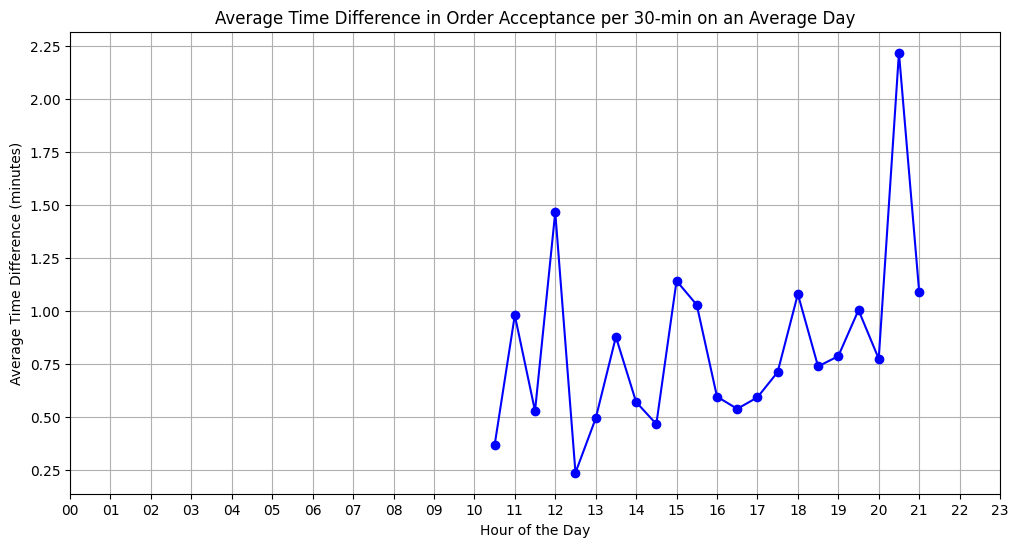

In [83]:
def time_difference_in_order_acceptance_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    accepted_timestamp = "order_updated_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[accepted_timestamp] - df[order_timestamp]
    ).dt.total_seconds() / 60

    # Calculate the average time difference for each interval on an average day
    average_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting the average time difference in order acceptance per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        average_time_difference, marker="o", linestyle="-", color="blue", markersize=6
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Time Difference (minutes)")
    plt.title(
        f"Average Time Difference in Order Acceptance per {interval}-min on an Average Day"
    )
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.show()


time_difference_in_order_acceptance_per_interval(df, 30)

checkout any major events 
look at seasionality of the month